# Optimal lookback momentum strategy

This code finds the optimal momentum lookback for a selection of country ETFs. The strategy default is with 3 long legs and no short legs. First, we load all the necessary packages. For more detailed explanation of the strategy and the formulas used for return, turnover etc. please reefer to the report generated in your project_momentum/reports file.

In [1]:
import yfinance as yf #for pulling the data
import numpy as np #for calculations and formatting
from numpy.linalg import inv #for calculations and formatting
import pandas as pd #for calculations and formatting
import matplotlib.pyplot as plt #for graphs
import os #for saving the plots and data files
from tabulate import tabulate #for creating tables
from scipy.stats import skew, kurtosis #for statistics
import seaborn as sns #for plot colors
from dash import Dash, dcc, html, Input, Output # dash environment for interactive plotting
import plotly.graph_objects as go # plotly for interactive plotting
from plotly.colors import qualitative # qualitative for colorblind friendly plots

## Parameter adjustment
The default for the strategy is set for the below parameters, however the user can adjust them however they wish - while keeping in mind the limits listed above each parameter.

### Time frame
First you can choose the start and end date of your strategy.

In [2]:
# The time series needs to be at least 24 months long in order to work
# we reccommend taking a series of at least 5 years to make the results representable
start_date = '2014-01-01'
end_date = '2024-09-20'

### Investmen universe

Next you can choose which countries to include in the investment universe - below is the list with tickers

1. MSCI USA
ETF Name: iShares MSCI USA ETF
Yahoo Ticker: EUSA
2. MSCI China
ETF Name: iShares MSCI China ETF
Yahoo Ticker: MCHI
3. MSCI Japan
ETF Name: iShares MSCI Japan ETF
Yahoo Ticker: EWJ
4. MSCI India
ETF Name: iShares MSCI India ETF
Yahoo Ticker: INDA
5. MSCI Brazil
ETF Name: iShares MSCI Brazil ETF
Yahoo Ticker: EWZ
6. MSCI Canada
ETF Name: iShares MSCI Canada ETF
Yahoo Ticker: EWC
7. MSCI Mexico
ETF Name: iShares MSCI Mexico ETF
Yahoo Ticker: EWW
8. MSCI South Korea
ETF Name: iShares MSCI South Korea ETF
Yahoo Ticker: EWY
9. MSCI Germany
ETF Name: iShares MSCI Germany ETF
Yahoo Ticker: EWG
10. MSCI United Kingdom
ETF Name: iShares MSCI United Kingdom ETF
Yahoo Ticker: EWU
11. MSCI Australia
ETF Name: iShares MSCI Australia ETF
Yahoo Ticker: EWA
12. MSCI Switzerland
ETF Name: iShares MSCI Switzerland ETF
Yahoo Ticker: EWL
13. MSCI Hong Kong
ETF Name: iShares MSCI Hong Kong ETF
Yahoo Ticker: EWH
14. MSCI Singapore
ETF Name: iShares MSCI Singapore ETF
Yahoo Ticker: EWS
15. MSCI Taiwan
ETF Name: iShares MSCI Taiwan ETF
Yahoo Ticker: EWT
16. MSCI Italy
ETF Name: iShares MSCI Italy ETF
Yahoo Ticker: EWI
17. MSCI Spain
ETF Name: iShares MSCI Spain ETF
Yahoo Ticker: EWP

In [3]:
# Here you can choose the countries in scope 
#If you remove certain tickers you need to remove corresponding country names in new_col_names_list  
country_list = ['EUSA', 'MCHI', 'EWJ', 'INDA', 'EWZ', 'EWC', 'EWW', 'EWY','EWG', 'EWU', 'EWA', 'EWL', 'EWH', 
                'EWS', 'EWT', 'EWI', 'EWP' ]
new_col_names_list = [ 'USA','China', 'Japan', 'India', 'Brazil', 'Canada', 'Mexico', 'South Korea',
                    'Germany', 'UK', 'Australia', 'Switzerland', 'Hong Kong', 'Singapore', 
                    'Taiwan', 'Italy', 'Spain']

### Risk free rate measure
Next you can specify what you wish to use as a risk free measure - we use the US 3-Month Treasury rate

In [4]:
#risk free - if you change it keep in mind that the insturments you replace it with is also stated in annual returns
Rf_list = ['^IRX']

### Lookbacks
Here you can specify what length of lookbacks you wish to investingate. We search for the optimal lookback withing 1-24 months

In [5]:
max_lookback = 24  # Maximum lookback period
#for visualisation - How many top&bottom strategies do you want to show in the graphs?
#x can be between 1 and 3
x=3 #shows graphs of only top 3 and bottom 3 performing lookback strategies

### Short and long lags
Choose how many country ETFs you will go long and how many you will go short. Keep in mind that you should choose the number that is at least smaller than the number of all ETFs you chose in the "Investment universe" step divided by 2

In [6]:
nLong = 3 #number of ETFs the strategy goes long (buys)
nShort = 0 #number of ETFs the strategy shorts (sells)

### Transaction costs

To make the strategy more realistic we include returns including the transaction costs. Here you can set that value.

In [7]:
tCost = 0.001

# Downloading data

## 1. ETF price data 

Here we download ETF price data from Yahoo finance and save it as raw data. Then we process it for further use in the backtest. The processed data is also saved separately. In the end we also show the summary statistics of the ETF price data for each country ETF.

In [8]:
#download ETF price data from Yahoo
ETFPrices = yf.download(country_list, 
                   start=start_date, 
                   end=end_date)
ETFPrices = pd.DataFrame(ETFPrices)

#save the raw data to data/raw file
# Get the current working directory
current_directory = os.getcwd()
# Directory path
directory_add_on = './data/raw/ETFPrices.csv'

# Concatenate paths
full_directory_path = os.path.join(current_directory, directory_add_on)

# Save DataFrame as CSV
ETFPrices.to_csv(full_directory_path, index=False)


[*********************100%***********************]  17 of 17 completed


In [9]:
# Keep only 'Adjusted Close' columns
ETFPrices = ETFPrices[[ 'Adj Close']]
ETFPrices = ETFPrices.rename(columns={'Adj Close': 'Price'}) #rename it for clearer understanding

ETFPrices.columns = new_col_names_list#only for the purposes of creating a nice looking table for descriptive statistics
#Date is downloaded as an index and we want to add it as a column
# Step 1: Access the date index
date_index = ETFPrices.index.tolist()  # Convert the index to a list
# Step 2: Add the date as a column (if necessary)
ETFPrices['Date'] = ETFPrices.index  # Add the date index as a new column

#saving the processed version of the data under data/processed
# Get the current working directory
current_directory = os.getcwd()
# Directory path
directory_add_on = './data/processed/ETFPrices_processed.csv'

# Concatenate paths
full_directory_path = os.path.join(current_directory, directory_add_on)

# Save DataFrame as CSV
ETFPrices.to_csv(full_directory_path, index=False)

In [10]:
#summary statistics for price data
# Generate summary statistics using .describe()
summary_stats = ETFPrices.describe().transpose()

# Format the summary statistics table 
summary_stats['Mean'] = summary_stats['mean']
summary_stats['Std'] = summary_stats['std']
summary_stats['Min'] = summary_stats['min']
summary_stats['25%'] = summary_stats['25%']
summary_stats['50%'] = summary_stats['50%']
summary_stats['75%'] = summary_stats['75%']
summary_stats['Max'] = summary_stats['max']

# Select and order the columns for a clean output
summary_stats = summary_stats[['Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']]

# Display the table using tabulate 
print(tabulate(summary_stats, headers='keys', tablefmt='pipe', floatfmt=".4f"))

|             |    Mean |     Std |     Min |     25% |     50% |     75% |     Max |
|:------------|--------:|--------:|--------:|--------:|--------:|--------:|--------:|
| USA         | 56.7352 | 17.6018 | 31.1307 | 39.8472 | 52.5221 | 73.6415 | 95.0078 |
| China       | 18.0947 |  3.3723 | 10.7066 | 15.6059 | 17.2929 | 21.2886 | 26.8200 |
| Japan       | 27.2604 |  5.7840 | 15.5576 | 22.9199 | 25.1957 | 33.0867 | 41.1500 |
| India       | 25.0526 |  3.4533 | 15.8377 | 22.5065 | 24.6239 | 27.3886 | 33.0900 |
| Brazil      | 18.5063 |  2.7380 | 12.8342 | 16.0820 | 18.7257 | 20.5221 | 25.0314 |
| Canada      | 24.4386 |  4.8193 | 15.4510 | 21.3958 | 23.6051 | 27.0771 | 38.8500 |
| Mexico      | 51.8783 |  8.9993 | 35.8464 | 44.1717 | 51.6706 | 58.0698 | 71.9700 |
| South Korea | 34.6748 |  8.0372 | 22.9353 | 27.3344 | 31.9130 | 42.1525 | 52.8500 |
| Germany     | 24.8497 |  3.2880 | 15.8527 | 22.7738 | 24.9592 | 26.7931 | 35.0700 |
| UK          | 17.6126 |  1.7554 | 12.5848 | 16.4578 

## 2. Risk free rate data

In the next step we do similar data downloading and processing for the risk free rate data. This data is only used when calculating the return series for total return when the number of short lags (nShort) is not equal to zero.

In [11]:
#download risk free rate data to add to long-short returns 
Rf_Daily = yf.download(Rf_list, 
                   start=start_date, 
                   end=end_date)
Rf_Daily = pd.DataFrame(Rf_Daily)

#save raw data in data/raw
# Directory path
directory_add_on = './data/raw/Rf.csv'

# Concatenate paths
full_directory_path = os.path.join(current_directory, directory_add_on)

# Save DataFrame as CSV
Rf_Daily.to_csv(full_directory_path, index=False)

# Keep only 'Adjusted Close' columns
Rf_Daily = Rf_Daily[[ 'Adj Close']]
Rf_Daily = Rf_Daily.rename(columns={'Adj Close': 'Rate'})
Rf_Daily = (1 + Rf_Daily) ** (1 / 365) - 1 #adjust so that the returns are daily not annual

# Resample to monthly frequency using the mean of each month (the strategy is rebalanced monthly so we only need monthly Rf)
Rf_Monthly = Rf_Daily.resample('M').mean()
Rf_Monthly_x = Rf_Monthly # Extra to get first month too for interactive plots
Rf_Monthly = Rf_Monthly.to_numpy().flatten()#  #for this backtest we always have returns in decimals
Rf_Monthly_desc = pd.DataFrame(Rf_Monthly)*100 #for descriptive statistics we need the data frame format

#save the processed data in data/processed
# Directory path
directory_add_on = './data/processed/Rf.csv'

# Concatenate paths
full_directory_path = os.path.join(current_directory, directory_add_on)

# Save DataFrame as CSV
Rf_Daily.to_csv(full_directory_path, index=False)

[*********************100%***********************]  1 of 1 completed


In [12]:
#summary statistics for Rf data
# Generate summary statistics using .describe()
summary_stats = Rf_Monthly_desc.describe().transpose()

# Format the summary statistics table similar to Stargazer style
summary_stats['Mean'] = summary_stats['mean']
summary_stats['Std'] = summary_stats['std']
summary_stats['Min'] = summary_stats['min']
summary_stats['25%'] = summary_stats['25%']
summary_stats['50%'] = summary_stats['50%']
summary_stats['75%'] = summary_stats['75%']
summary_stats['Max'] = summary_stats['max']

# Select and order the columns for a clean output
summary_stats = summary_stats[['Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']]

# Display the table using tabulate (pretty formatting)
print(tabulate(summary_stats, headers='keys', tablefmt='pipe', floatfmt=".4f"))

|    |   Mean |    Std |    Min |    25% |    50% |    75% |    Max |
|---:|-------:|-------:|-------:|-------:|-------:|-------:|-------:|
|  0 | 0.1923 | 0.1819 | 0.0018 | 0.0146 | 0.1499 | 0.3286 | 0.5065 |


# Get monthly returns

We initialize a function to get precise monthly start and end points that allows us to transfrom daily into monthly returns

In [13]:
#define function to transform daily data to monthly 
def get_first_and_last_day_in_period(date_list, n_digits):
    """
    Generate arrays listing the first and last observation in each period.
    Dates should be provided as numeric in the format YYYYMMDD, YYMMDD, or MMDD.
    The granularity of the period is defined by the number of digits that
    are removed from the date list. 2 digits will convert daily data to monthly data
    or monthly data to annual data. 4 digits will convert daily data to annual data.

    date_list: List or numpy array of dates in numeric format 
    n_digits: Number of digits to be removed from the date list to define the period
    :return: Two lists containing the indices of the first and last observations in each period
    """
    # Ensure the input is a numpy array
    date_list = np.array(date_list)
    n_obs = len(date_list)
    
    # Trim the date_list to the granularity defined by n_digits
    scaling_factor = 10 ** n_digits
    trimmed_date = date_list // scaling_factor

    # Detect the last day of each period by comparing consecutive entries
    last_day_of_period = np.diff(trimmed_date) != 0

    # Find the indices where the period changes (i.e., where last_day_of_period is True)
    last_day_list = np.where(last_day_of_period)[0]

    # Generate first day list based on last day list
    first_day_list = last_day_list + 1

    # Append the last observation as the last day of the final period
    last_day_list = np.append(last_day_list, n_obs - 1)
    first_day_list = np.insert(first_day_list, 0, 0)  # First period starts at index 0

    return first_day_list, last_day_list

In [14]:
#format date to numeric form YYYYMMDD for the 'get_first_and_last_day_in_period' function
date_list = pd.to_datetime(ETFPrices['Date'])
date_list = date_list.dt.strftime('%Y%m%d').astype(int)
#get the first and last day lists via the 'get_first_and_last_day_in_period' function
first_days_list, last_days_list = get_first_and_last_day_in_period(date_list, 2)#see what the actual output of the function is

## Transform ETF price data into return data

We take ETF price data and transform this into returns that can be used in determening momentum weights for each month.

In [15]:
# wee need the lenght of the time series and the number of assets in order to determine the return and weight series
nMonths = len(last_days_list) #number of months
nAssets = ETFPrices.shape[1] - 1  # number of assets # minus 1 for the Date column

In [16]:
#get returns from prices -- still daily
ETFReturns_Daily = np.zeros((len(ETFPrices) - 1 , nAssets))
# Calculate daily returns, ensuring indexing is correct
ETFPrices_wdate = ETFPrices.drop(columns=['Date']) #no date column in ETFPrices
ETFReturns_Daily[:, :] = ETFPrices_wdate.iloc[1:, :].values / ETFPrices_wdate.iloc[:-1, :].values - 1

In [17]:
# Compute monthlyDates4Fig using dates4Fig -- this is used later in the plot generation 
dates4Fig = ETFPrices['Date']
monthlyDates4Fig = dates4Fig.iloc[last_days_list]
monthlyDates4Fig = monthlyDates4Fig.drop(index=monthlyDates4Fig.index[0])
# Assuming dates4Fig is a pandas Series or list of dates in string format
# Convert dates4Fig to a pandas datetime format
dates4Fig = pd.to_datetime(dates4Fig)

In [18]:
#calculate returns on a monthly basis
ETFReturns_Monthly = np.zeros((nMonths, nAssets))
#compute the return in the month,  
for m in range(nMonths):
    first = max(first_days_list[m], 0)  
    last = last_days_list[m]
    
    # Calculate the cumulative product of returns over the period
    ETFReturns_Monthly[m, :] = np.prod(1 + ETFReturns_Daily[first:last, :], axis=0) -1
    

In [19]:
#summary statistics for monthly return data
# Generate summary statistics using .describe()
ETFReturns_Monthly_stats = pd.DataFrame(ETFReturns_Monthly)*100
ETFReturns_Monthly_stats.columns = new_col_names_list #to make names more intuitive - instead of ticker t shows countries
summary_stats = ETFReturns_Monthly_stats.describe().transpose()

# Format the summary statistics table
summary_stats['Mean'] = summary_stats['mean']
summary_stats['Std'] = summary_stats['std']
summary_stats['Min'] = summary_stats['min']
summary_stats['25%'] = summary_stats['25%']
summary_stats['50%'] = summary_stats['50%']
summary_stats['75%'] = summary_stats['75%']
summary_stats['Max'] = summary_stats['max']

# Select and order the columns for a clean output
summary_stats = summary_stats[['Mean', 'Std', 'Min', '25%', '50%', '75%', 'Max']]

# Display the table using tabulate (pretty formatting)
print(tabulate(summary_stats, headers='keys', tablefmt='pipe', floatfmt=".4f"))

|             |    Mean |    Std |      Min |     25% |    50% |    75% |     Max |
|:------------|--------:|-------:|---------:|--------:|-------:|-------:|--------:|
| USA         |  0.9128 | 4.9083 | -21.3978 | -1.5647 | 1.0328 | 3.6031 | 19.8197 |
| China       |  0.4322 | 5.5088 | -23.8981 | -2.2862 | 0.6936 | 3.1525 | 14.2857 |
| Japan       |  0.5014 | 5.0193 | -22.4352 | -2.1277 | 0.6689 | 3.4179 | 16.7869 |
| India       |  0.3173 | 5.6100 | -19.3391 | -3.3910 | 0.5559 | 3.3786 | 15.7017 |
| Brazil      |  0.0598 | 5.2179 | -13.0200 | -2.9958 | 0.1482 | 3.4229 | 19.8204 |
| Canada      |  0.4955 | 6.0388 | -23.8078 | -3.2110 | 0.5869 | 4.3456 | 22.4700 |
| Mexico      |  0.3849 | 3.9212 |  -9.5646 | -1.6435 | 0.4796 | 2.6594 | 10.7802 |
| South Korea |  0.5052 | 4.0434 |  -8.6308 | -2.2178 | 0.5592 | 3.6159 |  9.8617 |
| Germany     |  0.2832 | 5.8583 | -24.4048 | -4.1077 | 0.1236 | 4.0103 | 24.7437 |
| UK          |  0.3003 | 5.0236 | -20.4128 | -2.9900 | 0.2349 | 3.5769 | 15

## Calculate monthly weights

We initiate a function that calculates the weights for the strategy. If you wish to see the exact formulas we use please refer to the report generated in your project_momentum/report file.

In [20]:
#define a function to calculate weights of the momentum strategy that also loops for different lookback periods
def long_short_momentum(returns, lookback_months, n_longs, n_shorts, long_high_values):
    """
    Computes long and short momentum weights based on past returns.
    
    Parameters:
    - lookback_months: Number of months to look back for momentum calculation.
    - n_longs: Number of assets to hold long.
    - n_shorts: Number of assets to hold short.
    - long_high_values: If 1, long the assets with the highest returns; if 0, long the lowest returns.
    
    Returns:
    - weights: weights for long and short positions for each month.
    """
    # Ensure returns is a NumPy array
    returns = np.array(returns)

    # Get the number of months and assets
    n_months, n_assets = returns.shape

    # Initialize weights
    weights = np.zeros((n_months, n_assets))

    # Loop through each month to calculate weights
    for i in range(n_months):
        # Skip the calculation if there aren't enough months to look back
        if i < lookback_months:
            continue
        
        # Calculate cumulative returns for the lookback period
        cumulative_returns = np.prod(1 + returns[i - lookback_months:i, :], axis=0) - 1  # Cumulative returns

        # Reset weights for this month
        weights[i, :] = 0  # Reset weights for this month

        # Get valid indices for long and short positions
        if long_high_values == 0:
            # Get the indices of the top n_longs based on cumulative returns
            valid_long_indices = np.argsort(cumulative_returns)[-n_longs:]  # Lowest
            valid_short_indices = np.argsort(cumulative_returns)[:n_shorts]  # Highest
        else:
            valid_long_indices = np.argsort(cumulative_returns)[:n_longs]  # Highest
            valid_short_indices = np.argsort(cumulative_returns)[-n_shorts:]  # Lowest

        # Ensure we only assign weights if we have valid long indices
        if n_longs > 0 and valid_long_indices.size > 0:
            weights[i, valid_long_indices] = 1 / n_longs  # Assign equal weight to top n_longs

        # Ensure we only assign weights if we have valid short indices
        if n_shorts > 0 and valid_short_indices.size > 0:
            weights[i, valid_short_indices] = -1 / n_shorts  # Assign equal weight to bottom n_shorts

    # Remove any rows that have NaN weights
    weights = weights[~np.all(np.isnan(weights), axis=1)]
    
    return weights

In [21]:
#calculate weights for strategy
# Initialize a dictionary to store the weights for each lookback period
weights_by_lookback = {}

# Loop through each lookback period from 1 to 24 months
for lookback_months in range(1, max_lookback + 1):
    # Calculate the momentum weights for the current lookback period
    momLSWeights = long_short_momentum(ETFReturns_Monthly, lookback_months, nLong, nShort, 1)
    
    # Store the weights in the dictionary with the lookback period as the key
    weights_by_lookback[lookback_months] = momLSWeights


## Strategy return calcultaion

We calculate the returns of the strategy. For thsi we simply multiply the ETF Monthly returns with strategy weights we calculated in the firt step and sum the return for each month. We also include calculations for turnover and apply trading costs based on that.

In [22]:
# Initialize dictionaries to store NAVs, returns, and turnover for each strategy and the benchmark
nav_by_lookback = {}
nav_wTC_by_lookback = {}
turnover_by_lookback = {}
strategy_returns_by_lookback = {}
strategy_returns_by_lookback_wTC = {}
benchmark_returns = []
benchmark_returns_wTC = []  # Added for benchmark returns with transaction costs
benchmark_nav = []
benchmark_nav_wTC = []  # Added for benchmark NAV with transaction costs
benchmark_turnover = []  # Added for benchmark turnover

# Assume starting NAV is 1 for all strategies
initial_nav = 1

colors = plt.cm.Set1(np.linspace(0, 1, max_lookback))

benchmark_weights = np.ones(nAssets) / nAssets  # Start equally weighted

# Loop through each lookback period from 1 to max_lookback
for lookback_months in range(1, max_lookback + 1):
    # Retrieve the weights for the current lookback period
    momLSWeights = weights_by_lookback[lookback_months]

    # Calculate strategy returns for each month by multiplying weights with returns
    strategy_returns = np.sum(momLSWeights * ETFReturns_Monthly, axis=1)
    if nShort != 0:
        strategy_returns += Rf_Monthly
    else:
        strategy_returns = strategy_returns

    # --- Benchmark Returns ---
    # Compute returns for the benchmark based on the equally weighted portfolio
    benchmark_period_returns = np.sum(benchmark_weights * ETFReturns_Monthly, axis=1)

    # Calculate new weights for the benchmark after applying returns (drifted weights)
    benchmark_cum_returns = np.cumprod(1 + ETFReturns_Monthly, axis=0)  # Cumulative returns for each ETF
    drifted_weights = benchmark_cum_returns / np.sum(benchmark_cum_returns, axis=1, keepdims=True)  # Normalize

    # Calculate turnover required to rebalance to equal weights
    turnover_bm = np.sum(np.abs(drifted_weights - benchmark_weights), axis=1)
    benchmark_turnover = turnover_bm[max_lookback:]  # Adjust for lookback cutoff
    benchmark_turnover_costs = benchmark_turnover * tCost  # Compute transaction costs for the benchmark

    # Adjust benchmark returns for transaction costs
    benchmark_returns_wTC = benchmark_period_returns[max_lookback:] - benchmark_turnover_costs
    
    # Compute the cumulative NAV for the benchmark and normalize to start at 1
    if lookback_months == max_lookback:
        raw_benchmark_nav = np.cumprod(1 + benchmark_period_returns[max_lookback:])
        benchmark_nav = raw_benchmark_nav / raw_benchmark_nav[0]  # Normalize to start at 1

        raw_benchmark_nav_wTC = np.cumprod(1 + benchmark_returns_wTC)
        benchmark_nav_wTC = raw_benchmark_nav_wTC / raw_benchmark_nav_wTC[0]  # Normalize to start at 1

    # --- Strategy NAV Calculation ---
    raw_nav = np.cumprod(1 + strategy_returns[max_lookback:])  # Adjust for lookback cutoff
    nav = raw_nav / raw_nav[0]  # Normalize to start at 1

    strategy_returns = strategy_returns[max_lookback:]  # Adjust for lookback cutoff
    nav_by_lookback[lookback_months] = nav  # Store the normalized NAV in the dictionary

    # --- Turnover and Costs ---
    turnover = np.sum(np.abs(momLSWeights[1:, :] - momLSWeights[:-1, :]), axis=1)
    turnover = np.insert(turnover, 0, 0)  # Adding a zero at the start
    turnover = turnover[max_lookback:]  # Adjust for lookback cutoff
    turnover_costs = turnover * tCost

    # Deduct turnover costs from strategy returns to get returns after trading costs
    cost_adjusted_strategy_returns = strategy_returns - turnover_costs

    # Update the NAV with adjusted returns and normalize to start at 1
    raw_navTC = np.cumprod(1 + cost_adjusted_strategy_returns)
    navTC = raw_navTC / raw_navTC[0]  # Normalize to start at 1

    nav_wTC_by_lookback[lookback_months] = navTC  # Store normalized cost-adjusted NAV
    turnover_by_lookback[lookback_months] = turnover  # Store turnover
    strategy_returns_by_lookback[lookback_months] = strategy_returns  # Store strategy returns
    strategy_returns_by_lookback_wTC[lookback_months] = cost_adjusted_strategy_returns  # Store adjusted returns

# Calculate the final NAV for each strategy and sort them
final_nav_values = {lookback: nav[-1] for lookback, nav in nav_by_lookback.items()}
sorted_lookbacks = sorted(final_nav_values, key=final_nav_values.get)

# Get the top 3 and bottom 3 strategies based on final NAV
top_x_lookbacks = sorted_lookbacks[-x:]  # Top x strategies
bottom_x_lookbacks = sorted_lookbacks[:x]  # Bottom x strategies


In [23]:
last_days_list = last_days_list[max_lookback:] #adjust fro lookback cutoff at max lookback
df_nav_by_lookback = pd.DataFrame(nav_by_lookback, index=dates4Fig.iloc[last_days_list])
df_nav_wTC_by_lookback = pd.DataFrame(nav_wTC_by_lookback, index=dates4Fig.iloc[last_days_list])
df_bmk = pd.DataFrame(benchmark_nav, index=dates4Fig.iloc[last_days_list])
# Rename columns to differentiate between no transaction costs and with transaction costs & rename benchmark column
df_nav_by_lookback.columns = [f"strat_{col}" for col in df_nav_by_lookback.columns]
df_nav_wTC_by_lookback.columns = [f"strat_wTC_{col}" for col in df_nav_wTC_by_lookback.columns]
df_bmk.rename(columns={0: 'Bmk'}, inplace=True)
# Join together dataframes
df_nav_dash = df_nav_by_lookback.join([df_nav_wTC_by_lookback, df_bmk], how='outer')  # 'outer' to include all cols from both DataFrames
df_nav_dash


,strat_1,strat_2,strat_3,strat_4,strat_5,strat_6,strat_7,strat_8,strat_9,strat_10,...,strat_wTC_16,strat_wTC_17,strat_wTC_18,strat_wTC_19,strat_wTC_20,strat_wTC_21,strat_wTC_22,strat_wTC_23,strat_wTC_24,Bmk
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-29 00:00:00+00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2016-02-29 00:00:00+00:00,0.981853,0.960471,0.960471,0.976022,0.973115,0.973115,1.022898,0.991481,1.022898,0.991481,...,1.007032,1.007032,1.007032,1.007032,0.972449,0.972449,0.972449,0.972449,1.007032,0.988574
2016-03-31 00:00:00+00:00,1.038860,1.016236,1.014814,1.031245,1.029615,1.076169,1.131224,1.105337,1.140362,1.105337,...,1.125909,1.113006,1.125909,1.113006,1.075432,1.075432,1.075432,1.075432,1.113006,1.058947
2016-04-29 00:00:00+00:00,1.077454,1.060927,1.054349,1.082484,1.089068,1.120825,1.190869,1.163616,1.186312,1.149875,...,1.207890,1.194789,1.207890,1.201529,1.154455,1.154455,1.154455,1.154455,1.194789,1.086847
2016-05-31 00:00:00+00:00,1.090827,1.066989,1.060966,1.079840,1.081283,1.095138,1.169179,1.130675,1.164705,1.142512,...,1.151077,1.139264,1.151755,1.123083,1.081926,1.079852,1.079852,1.079852,1.117580,1.059766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-31 00:00:00+00:00,1.619397,1.925723,1.592590,1.973606,2.097024,1.855226,2.107245,1.828098,2.085313,2.142540,...,1.536179,1.897835,1.736843,1.686570,1.487447,1.683136,1.445259,1.444386,1.949677,1.491415
2024-06-28 00:00:00+00:00,1.611468,1.916294,1.584792,1.963943,2.086757,1.846142,2.005472,1.739808,2.041968,2.104150,...,1.508654,1.863831,1.704565,1.605115,1.414617,1.652978,1.419363,1.418506,1.914743,1.472525
2024-07-31 00:00:00+00:00,1.633492,1.924488,1.602458,1.972341,2.095680,1.854037,2.006112,1.740363,2.042620,2.104822,...,1.500733,1.854044,1.695614,1.595616,1.415069,1.652404,1.418870,1.411058,1.904689,1.503917


In [24]:
#### These are the dfs we use in interactive plots ####
# Convert final_nav_values & strategy returns to  DataFrame
final_nav_values_data = pd.DataFrame(list(final_nav_values.items()), columns=["Lookback Period", "Final NAV"])

df_strategy_returns_by_lookback = pd.DataFrame(strategy_returns_by_lookback, index=dates4Fig.iloc[last_days_list])#I use this one
df_strategy_returns_by_lookback_wTC = pd.DataFrame(strategy_returns_by_lookback_wTC, index=dates4Fig.iloc[last_days_list])
Rf_Monthly_x=Rf_Monthly_x[max_lookback:]
df_Rf_Monthly = pd.DataFrame(Rf_Monthly_x.values, index=dates4Fig.iloc[last_days_list])#Iuse this one
df_Rf_Monthly.rename(columns={0: 'Rf'}, inplace=True)#i use this one
df_benchmark_period_returns = pd.DataFrame(benchmark_period_returns[max_lookback:])#i use this one

# Directory path
#directory_add_on2 = './data/processed/df_strategy_returns_by_lookback.csv'
#directory_add_on3 = './data/processed/df_strategy_returns_by_lookback_wTC.csv'
#directory_add_on4 = './data/processed/df_Rf_Monthly.csv'
# Concatenate paths
#full_directory_path2 = os.path.join(current_directory, directory_add_on2)
#full_directory_path3 = os.path.join(current_directory, directory_add_on3)
#full_directory_path4 = os.path.join(current_directory, directory_add_on4)

# Save DataFrame as CSV
#df_strategy_returns_by_lookback.to_csv(full_directory_path2, index=True)
#df_strategy_returns_by_lookback_wTC.to_csv(full_directory_path3, index=True)
#df_Rf_Monthly.to_csv(full_directory_path4, index=True)

# Visualization

## Static Plots

Here we create different plots for our strategy. The first one shows the performance of top x lookbacks with and without trading costs.  The second one is a plot comparing top x and bottom x lookback periods based on performance. Both graphs also show performance compared to the benchmark.

In [25]:
#getting data for x axis - dates
monthlyDates4Fig = monthlyDates4Fig[max_lookback:]
monthlyDates4Fig = [date.strftime('%Y') for date in monthlyDates4Fig]

In [26]:
# Set colorblind-friendly colors for top and bottom strategies
sns.set_palette("colorblind")
palette = sns.color_palette("colorblind")
top_color = palette[0]  # Blue
bottom_color = palette[1]  # Orange

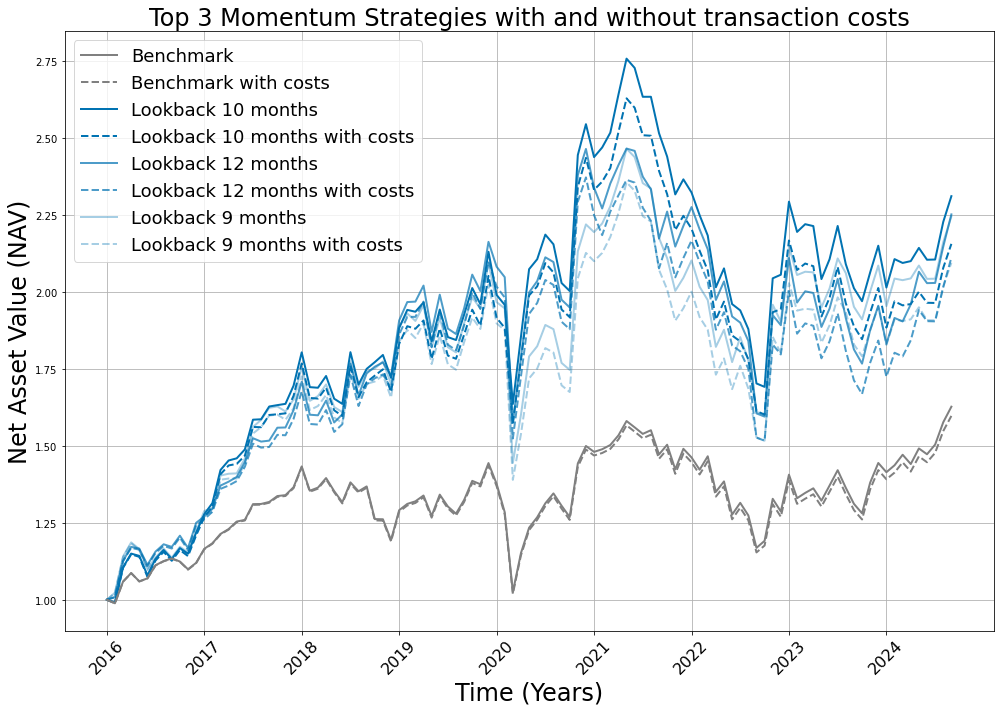

In [45]:
#plot1: top x lookbacks with and without trading costs

# To store legend entries for sorting
legend_entries = []

# Initialize the plot
plt.figure(figsize=(14, 10))

# Plot the NAVs for no TC 
for i, lookback_months in enumerate(top_x_lookbacks):
    alpha =  0.35 + 0.35 * i
    line1, = plt.plot(nav_by_lookback[lookback_months],
                      label=f'Lookback {lookback_months} months',
                      linestyle='-', linewidth=2, color=top_color, alpha=min(alpha, 1))  # Differentiated shades
    legend_entries.append((f'Lookback {lookback_months} months', line1))

# Plot the NAVs with TC 
for i, lookback_months in enumerate(top_x_lookbacks):
    alpha =  0.35 + 0.35 * i
    line1, = plt.plot(nav_wTC_by_lookback[lookback_months],
                      label=f'Lookback {lookback_months} months',
                      linestyle='--', linewidth=2, color=top_color, alpha=min(alpha, 1))  # Differentiated shades
    legend_entries.append((f'Lookback {lookback_months} months with costs', line1))


#add bechmark
benchmark_line, = plt.plot(benchmark_nav, label='Benchmark', linestyle='-', linewidth=2, color='gray')
legend_entries.append(('Benchmark', benchmark_line))

benchmark_line, = plt.plot(benchmark_nav_wTC, label='Benchmark with costs', linestyle='--', linewidth=2, color='gray')
legend_entries.append(('Benchmark with costs', benchmark_line))


# Sort legend entries alphabetically by the label
legend_entries.sort(key=lambda x: x[0])  # Sort by the label (first element of tuple)


# Unpack sorted labels and line objects - because we sort the returns to only show best x lookbacks
sorted_labels, sorted_lines = zip(*legend_entries)


# Add the sorted legend right at the edge of the upper left corner
plt.legend(sorted_lines, sorted_labels, loc='upper left', bbox_to_anchor=(0, 1), fontsize=18)

# Add x-axis ticks and labels
x_data_points = range(len(monthlyDates4Fig))  
x_labels = [monthlyDates4Fig[i] for i in range(0, len(monthlyDates4Fig), 12)]  # Yearly intervals
plt.xticks(ticks=range(0, len(monthlyDates4Fig), 12), labels=x_labels, rotation=45, fontsize=16)



# Additional plotting aesthetics
plt.title(f'Top {x} Momentum Strategies with and without transaction costs', fontsize=24)
plt.xlabel('Time (Years)', fontsize=24)
plt.ylabel('Net Asset Value (NAV)', fontsize=24)
plt.grid(True)
plt.tight_layout()

# Save the figure to the correct directory - for use in latex report
output_directory = os.path.join(current_directory, 'reports', 'figures')
os.makedirs(output_directory, exist_ok=True)
output_path = os.path.join(output_directory, 'fig_costs.pdf')
plt.savefig(output_path, format='pdf', dpi=300)
plt.show()


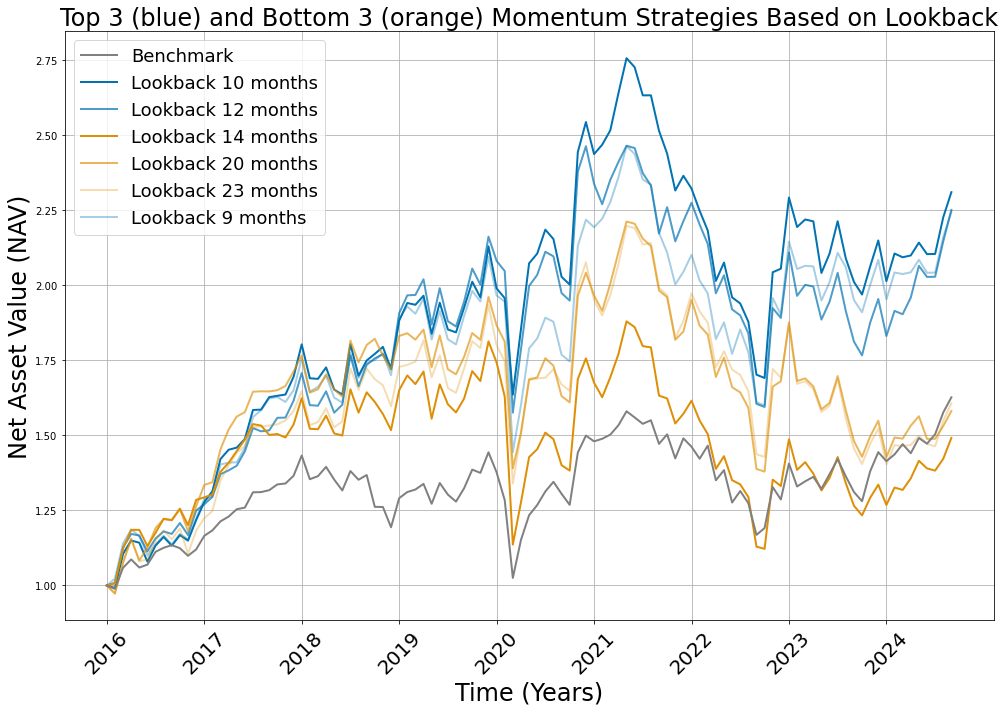

In [44]:
#Plot 2: Top versus bottom x lookbacks by performance

# To store legend entries for sorting
legend_entries = []

# Initialize the plot
plt.figure(figsize=(14, 10))

# Plot the NAVs for the top strategies
for i, lookback_months in enumerate(top_x_lookbacks):
    alpha =  0.35 + 0.35 * i #for differentaited shades
    line1, = plt.plot(nav_by_lookback[lookback_months],
                      label=f'Lookback {lookback_months} months',
                      linestyle='-', linewidth=2, color=top_color, alpha=min(alpha, 1))  # Adjust alpha
    legend_entries.append((f'Lookback {lookback_months} months', line1))

# Plot the NAVs for the bottom strategies 
for i, lookback_months in enumerate(bottom_x_lookbacks):
    alpha = 1 - 0.35 * i #for differentaited shades
    line1, = plt.plot(nav_by_lookback[lookback_months],
                      label=f'Lookback {lookback_months} months',
                      linestyle='-', linewidth=2, color=bottom_color, alpha=min(alpha, 1))  # Adjust alpha
    legend_entries.append((f'Lookback {lookback_months} months', line1))

#add bechmark
benchmark_line, = plt.plot(benchmark_nav, label='Benchmark', linestyle='-', linewidth=2, color='gray')    
legend_entries.append(('Benchmark', benchmark_line))

# Sort legend entries alphabetically by the label
legend_entries.sort(key=lambda x: x[0])  # Sort by the label (first element of tuple)


# Unpack sorted labels and line objects - because we sort the returns to only show best x lookbacks and worst x lookbacks
sorted_labels, sorted_lines = zip(*legend_entries)


# Add the sorted legend right at the edge of the upper left corner
plt.legend(sorted_lines, sorted_labels, loc='upper left', bbox_to_anchor=(0, 1), fontsize=18)

# Add x-axis ticks and labels
x_data_points = range(len(monthlyDates4Fig))  # Example indices from MonthlyData4Fig
x_labels = [monthlyDates4Fig[i] for i in range(0, len(monthlyDates4Fig), 12)]  # Yearly intervals
plt.xticks(ticks=range(0, len(monthlyDates4Fig), 12), labels=x_labels, rotation=45, fontsize=20)



# Additional plotting aesthetic
plt.title(f'Top {x} (blue) and Bottom {x} (orange) Momentum Strategies Based on Lookback', fontsize=24)
plt.xlabel('Time (Years)', fontsize=24)
plt.ylabel('Net Asset Value (NAV)', fontsize=24)
plt.grid(True)
plt.tight_layout()
# Save the figure to the correct directory
output_directory = os.path.join(current_directory, 'reports', 'figures')
os.makedirs(output_directory, exist_ok=True)
output_path = os.path.join(output_directory, 'fig_bm.pdf')
plt.savefig(output_path, format='pdf', dpi=300)
plt.show()


## Interactive Plot
We use dash and plotly in order to present a nicely editable plot, in order to investigate and compare the different lookback strategies.\
After running the next cell, one can access the interactive plot under: http://127.0.0.1:8061/

In [29]:
# Initialize Dash app
app = Dash(__name__)

# Define the layout
app.layout = html.Div([
    html.H1("Interactive NAV Visualization", style={'text-align': 'center'}),
    
    # Dropdown for best/worst strategies
    html.Label("Choose Strategy Ranking:"),
    dcc.Checklist(
        id='ranking-options',
        options=[
            {'label': 'Best Strategies', 'value': 'best'},
            {'label': 'Worst Strategies', 'value': 'worst'}
        ],
        value=['best'],  # Default to showing best strategies
        inline=True
    ),

    # Number input for specifying how many strategies to display
    html.Label("Number of Strategies to Display (Per Category):"),
    dcc.Input(
        id='num-strategies-input',
        type='number',
        min=1,
        max=24,
        step=1,
        value=5,  # Default to showing 5 strategies per category
        style={'margin-bottom': '20px'}
    ),

    # Checkboxes for transaction costs and benchmark
    html.Label("Include Transaction Costs and Benchmark:"),
    dcc.Checklist(
        id='tc-checklist',
        options=[
            {'label': 'With TC', 'value': 'with_tc'},
            {'label': 'Without TC', 'value': 'without_tc'},
            {'label': 'Benchmark', 'value': 'benchmark'}
        ],
        value=['with_tc', 'without_tc'],  # Default to showing strategies with and without TC
        inline=True
    ),

    # Graph to display the NAVs
    dcc.Graph(id='nav-plot')
])

# Callback to update the graph based on user inputs
@app.callback(
    Output('nav-plot', 'figure'),
    [Input('ranking-options', 'value'),
     Input('num-strategies-input', 'value'),
     Input('tc-checklist', 'value')]
)
def update_graph(ranking_options, num_strategies, include_options):
    # Filter columns based on the selected transaction cost options
    selected_columns = []
    if 'with_tc' in include_options:
        selected_columns += [col for col in df_nav_dash.columns if col.startswith('strat_wTC_')]
    if 'without_tc' in include_options:
        selected_columns += [col for col in df_nav_dash.columns if col.startswith('strat_') and not col.startswith('strat_wTC_')]

    # Compute the NAV ranking based on the last NAV value
    nav_ranking = df_nav_dash[selected_columns].iloc[-1]

    # Create the plot
    fig = go.Figure()

    # Define a colorblind-friendly palette
    color_palette = qualitative.Safe  # This palette is designed for colorblind accessibility
    palette_index = 0

    if 'best' in ranking_options:
        # Select top strategies
        best_columns = nav_ranking.nlargest(num_strategies).index
        for col in best_columns:
            fig.add_trace(go.Scatter(
                x=df_nav_dash.index,
                y=df_nav_dash[col],
                mode='lines',
                name=f"Best - {col}",
                line=dict(color=color_palette[palette_index % len(color_palette)])
            ))
            palette_index += 1

    if 'worst' in ranking_options:
        # Select bottom strategies
        worst_columns = nav_ranking.nsmallest(num_strategies).index
        for col in worst_columns:
            fig.add_trace(go.Scatter(
                x=df_nav_dash.index,
                y=df_nav_dash[col],
                mode='lines',
                name=f"Worst - {col}",
                line=dict(color=color_palette[palette_index % len(color_palette)])
            ))
            palette_index += 1

    # Add the benchmark line if selected
    if 'benchmark' in include_options:
        fig.add_trace(go.Scatter(
            x=df_nav_dash.index,
            y=df_nav_dash['Bmk'],
            mode='lines',
            name='Benchmark',
            line=dict(color='gold', dash='dash')  # Distinguish benchmark visually
        ))

    # Update layout
    fig.update_layout(
        title="NAV of Selected Strategies",
        xaxis_title="Date",
        yaxis_title="NAV",
        legend_title="Strategies",
        template="plotly_dark",
        height=700,
        width=1200,
        showlegend=True  # Ensure legend is always displayed
    )

    return fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True, host="0.0.0.0", port=8061)

# Go to website: http://127.0.0.1:8061/

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=8061): Max retries exceeded with url: /_alive_1d718152-b43b-4a79-a0b5-f418d8844d22 (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x0000023A7378DF70>: Failed to establish a new connection: [WinError 10049] The requested address is not valid in its context'))

# Performance statistics

Here we initiate the function containing different performance statistics and run it for all our lookback strategies and also for the benchmark. For a nice table view of the performance statistics please refer to the report saved in project_momentum/reprots file.

In [30]:
def performance_stats(annualization_factor, strategy_xs_returns, rf):
    # Total strategy returns
    strategy_total_returns = strategy_xs_returns + rf

    # Final portfolio and risk-free values
    final_pf_value = np.prod(1 + strategy_total_returns)
    final_rf_value = np.prod(1 + rf)

    # Number of observations and years
    n_obs = len(rf)
    n_years = n_obs / annualization_factor

    # Average returns
    avg_total_return = (final_pf_value ** (1 / n_years) - 1) 
    avg_rf = (final_rf_value ** (1 / n_years) - 1) 
    avg_xs_return = avg_total_return - avg_rf 

    # Standard deviation of excess returns
    std_xs_return = np.sqrt(annualization_factor) * np.std(strategy_xs_returns)

    # Sharpe Ratio
    sharpe_ratio = avg_xs_return / std_xs_return

    # Worst and best returns
    worst = np.min(strategy_xs_returns)
    best = np.max(strategy_xs_returns)

    # Skewness and kurtosis
    skewness = skew(strategy_xs_returns)
    kurt = kurtosis(strategy_xs_returns)

    # Return all results as a dictionary
    return {
        "avg_total_return": avg_total_return *100,
        "avg_xs_return": avg_xs_return*100,
        "std_xs_return": std_xs_return,
        "sharpe_ratio": sharpe_ratio,
        "worst": worst*100,
        "best": best*100,
        "skewness": skewness,
        "kurtosis": kurt,

    }

In [31]:
df_Rf_Monthly_rep = pd.concat([df_Rf_Monthly] * max_lookback, axis=1) #replicate the Rf series so it has same dimention as strategy returns
df_Rf_Monthly_rep = df_Rf_Monthly_rep.apply(pd.to_numeric, errors='coerce')
df_strategy_returns_by_lookback = df_strategy_returns_by_lookback.apply(pd.to_numeric, errors='coerce')
df_Rf_Monthly_rep.columns = df_strategy_returns_by_lookback.columns
performance_stats_strategy = performance_stats(12,df_strategy_returns_by_lookback , df_Rf_Monthly_rep)
performance_stats_bm = performance_stats(12,df_benchmark_period_returns.iloc[:, 0].values , df_Rf_Monthly['Rf'].values)

C:\Users\jazbi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'

C:\Users\jazbi\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning:

In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'



In [32]:
# Create DataFrame
df = pd.DataFrame(performance_stats_strategy)

# Add lookbacks column
df.insert(0, 'lookbacks', range(1, max_lookback +1))

# Round values to two decimal places
df = df.round(2)

# Display the table
print(df.to_string(index=False))

 lookbacks  avg_total_return  avg_xs_return  std_xs_return  sharpe_ratio  worst  best  skewness  kurtosis
         1              9.06           6.22           0.21          0.29 -32.72 22.39     -0.86      8.07
         2             11.58           8.74           0.20          0.43 -25.28 22.39     -0.09      4.67
         3              9.28           6.43           0.20          0.32 -24.00 22.39      0.07      4.18
         4             11.53           8.68           0.21          0.42 -27.39 22.39     -0.26      5.63
         5             12.45           9.60           0.19          0.50 -24.00 22.39      0.09      5.28
         6             11.29           8.45           0.20          0.43 -24.00 22.39     -0.05      4.49
         7             11.98           9.13           0.20          0.45 -25.49 22.39     -0.08      4.46
         8             10.38           7.53           0.20          0.37 -24.33 22.39      0.23      4.44
         9             12.50           9.66   

In [33]:
# Create DataFrame with a single row
df_bm = pd.DataFrame([performance_stats_bm])
df_bm= df_bm.round(2)
# Add a column with a label
df_bm.insert(0, 'benchmark', 'benchmark')

# Display the table
print(df_bm.to_string(index=False))

benchmark  avg_total_return  avg_xs_return  std_xs_return  sharpe_ratio  worst  best  skewness  kurtosis
benchmark              8.16           5.31           0.16          0.33 -20.19 13.71     -0.51      3.12
